In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

%matplotlib inline

In [2]:
def pure(*args, **kwargs):
    return 1

def damped(*args, **kwargs):
    return kwargs['alpha']

def armijo_step(x, h, **kwargs):
    f = kwargs["f"]
    gradf = kwargs["gradf"]
    gradient = gradf(x)
    alpha = 1
    x_next = x + alpha * h
    while f(x_next) > f(x) + 0.3 * alpha * gradient.dot(x_next - x):
        alpha *= 0.6
        x_next = x + alpha * h
    return alpha

def func_conv(x, **kwargs):
    return np.linalg.norm(kwargs['f'](x) - kwargs['f_true'])

def grad_conv(x, **kwargs):
    return np.linalg.norm(kwargs['gradf'](x))

def bb_first(g, s):
    return g.dot(s) / g.dot(g)

def bb_second(g, s):
    return s.dot(s) / g.dot(s)

In [3]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter,
           step_selection=pure, convergence=grad_conv, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_args = {"f": f, "gradf": gradf}
    opt_args.update(kwargs)
    conv_values = []
    timestamps = []
    start = timer()
    while iteration < num_iter:
        if len(x) > 1:
            h = np.linalg.solve(hessf(x), -gradf(x))
        else:
            h = -1 / hessf(x)[0] * gradf(x)[0]
        alpha = step_selection(x, h, **opt_args)
        x = x + alpha * h
        conv_value = convergence(x, **opt_args)
        timestamps.append((timer() - start) * 1000) 
        conv_values.append(conv_value)
        if conv_value < epsilon:
            break
        iteration += 1

    end = timer()
    time = (end - start) * 1000
    result = {"x": x, "conv_values": conv_values, 
              "num_iter": len(conv_values), "time": time, 
              "time_per_iter": time / len(conv_values), 
              "timestamps": timestamps}
    return result

In [4]:
def QuasiNewton(f, gradf, hessf, x0, epsilon, num_iter,  # hessf not used
                step_selection=bb_first, convergence=grad_conv, **kwargs):
    x_prev = x0.copy()
    iteration = 0
    opt_args = {"f": f, "gradf": gradf}
    opt_args.update(kwargs)
    conv_values = []
    timestamps = []
    start = timer()
    alpha = 0.0001
    while iteration < num_iter:
        current_grad = gradf(x_prev)
        if iteration != 0:
            g = current_grad - prev_grad
            alpha = step_selection(g, s)
        x_next = x_prev - alpha * current_grad
        conv_value = convergence(x_next, **opt_args)
        conv_values.append(conv_value)
        curr = timer()
        timestamps.append((curr - start) * 1000)
        if (grad_conv(x_next, **opt_args) < epsilon) or (conv_value < epsilon):
            break
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
        iteration += 1

    end = timer()
    time = (end - start) * 1000
    result = {"x": x_prev, "conv_values": conv_values, 
              "num_iter": len(conv_values), "time": time, 
              "time_per_iter": time / len(conv_values), 
              "timestamps": timestamps}
    return result

## Optimal solution

Problem description is located at [Overleaf](https://www.overleaf.com/read/tbjdmwpxrycg).

In [5]:
N = 20
M = 10
A0 = np.random.uniform(-1, 1, (N, M)) * 10
A1 = np.random.uniform(-1, 1, (N, M))
b = np.random.uniform(-10, 10, N)

### Stochastic approximation

In [6]:
def show_res(f, gradf, hessf, x0, epsilon, num_iter, method, axs,
             step, convergence=grad_conv, conv_arg=None, value=None):
    meth_args = {"f_true": conv_arg, "alpha": value}
    result = method(f, gradf, hessf, x0, epsilon, num_iter, step,
                    convergence, **meth_args)
    label = method.__name__ + ", " + step.__name__
    if value is not None:
        label += ", alpha = " + str(value)
    print(label)
    
    iaxs = int(convergence.__name__ != 'grad_conv') * 2
    axs[iaxs].semilogy(np.arange(1, result['num_iter'] + 1), result['conv_values'], label=label)
    axs[iaxs + 1].semilogy(result['timestamps'], result['conv_values'], label=label)
    for key, value in result.items():
        if key not in ['conv_values', 'timestamps']:
            print(key, ": ", value)
    print('\n')
    

def compare(f, gradf, hessf, x0, epsilon, num_iter, damped_values):
    # Best solution for func_conv
    f_true = f(Newton(f, gradf, hessf, x0, epsilon**3, num_iter * 100)['x'])
    convergence = [grad_conv, func_conv]
    conv_arg = [None, f_true]
    method = [Newton, Newton, Newton, QuasiNewton, QuasiNewton]
    step = [pure, damped, armijo_step, bb_first, bb_second]
    
    fig, axs = plt.subplots(4, 1, figsize=(12, 24), dpi=200)
    for i in range(len(convergence)):
        print("\n--------------- %s ---------------\n" % convergence[i].__name__)
        for j in range(len(step)):
            if step[j].__name__ == 'damped':
                for val in damped_values:
                    show_res(f, gradf, hessf, x0, epsilon, num_iter, method[j], axs,
                             step[j], convergence[i], conv_arg[i], value=val)
            else:
                show_res(f, gradf, hessf, x0, epsilon, num_iter, method[j], axs,
                         step[j], convergence[i], conv_arg[i])
    
    axs[0].set_xlabel("Number of iterations")
    axs[0].set_ylabel(r"$||\nabla f(x_k)||$")
    axs[1].set_xlabel("Time (ms)")
    axs[1].set_ylabel(r"$||\nabla f(x_k)||$")
    axs[2].set_xlabel("Number of iterations")
    axs[2].set_ylabel(r"$|f(x_k) - f^*|$")
    axs[3].set_xlabel("Time (ms)")
    axs[3].set_ylabel(r"$|f(x_k) - f^*|$")
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[3].legend()

    fig.suptitle("Comparison of methods", y=0.92, fontsize=15)
    plt.show()

In [7]:
def f_stoch(x):
    return np.linalg.norm(A0 @ x - b)**2 + 1 / 3 * np.linalg.norm(A1 @ x)**2

def gradf_stoch(x):
    return 2 * A0.T @ (A0 @ x - b) + 2 / 3 * A1.T @ A1 @ x

def hessf_stoch(x):
    return 2 * A0.T @ A0 + 2 / 3 * A1.T @ A1


--------------- grad_conv ---------------

Newton, pure
x :  [-0.21552445  0.26580197 -0.35128237  0.52929198 -0.23515004 -0.32269931
  0.24354397 -1.08211703  0.72745633 -0.36008794]
num_iter :  1
time :  0.8324029913637787
time_per_iter :  0.8324029913637787


Newton, damped, alpha = 0.5
x :  [-0.21552445  0.26580197 -0.35128237  0.52929198 -0.23515004 -0.32269931
  0.24354397 -1.08211703  0.72745633 -0.36008794]
num_iter :  39
time :  4.956785007379949
time_per_iter :  0.12709705147128075


Newton, damped, alpha = 0.25
x :  [-0.21552445  0.26580197 -0.35128237  0.52929198 -0.23515004 -0.32269931
  0.24354397 -1.08211703  0.72745633 -0.36008794]
num_iter :  94
time :  6.771126005332917
time_per_iter :  0.0720332553758821


Newton, damped, alpha = 0.15
x :  [-0.21552445  0.26580197 -0.35128237  0.52929198 -0.23515004 -0.32269931
  0.24354397 -1.08211703  0.72745633 -0.36008794]
num_iter :  166
time :  10.889058001339436
time_per_iter :  0.06559673494782793


Newton, damped, alpha = 0

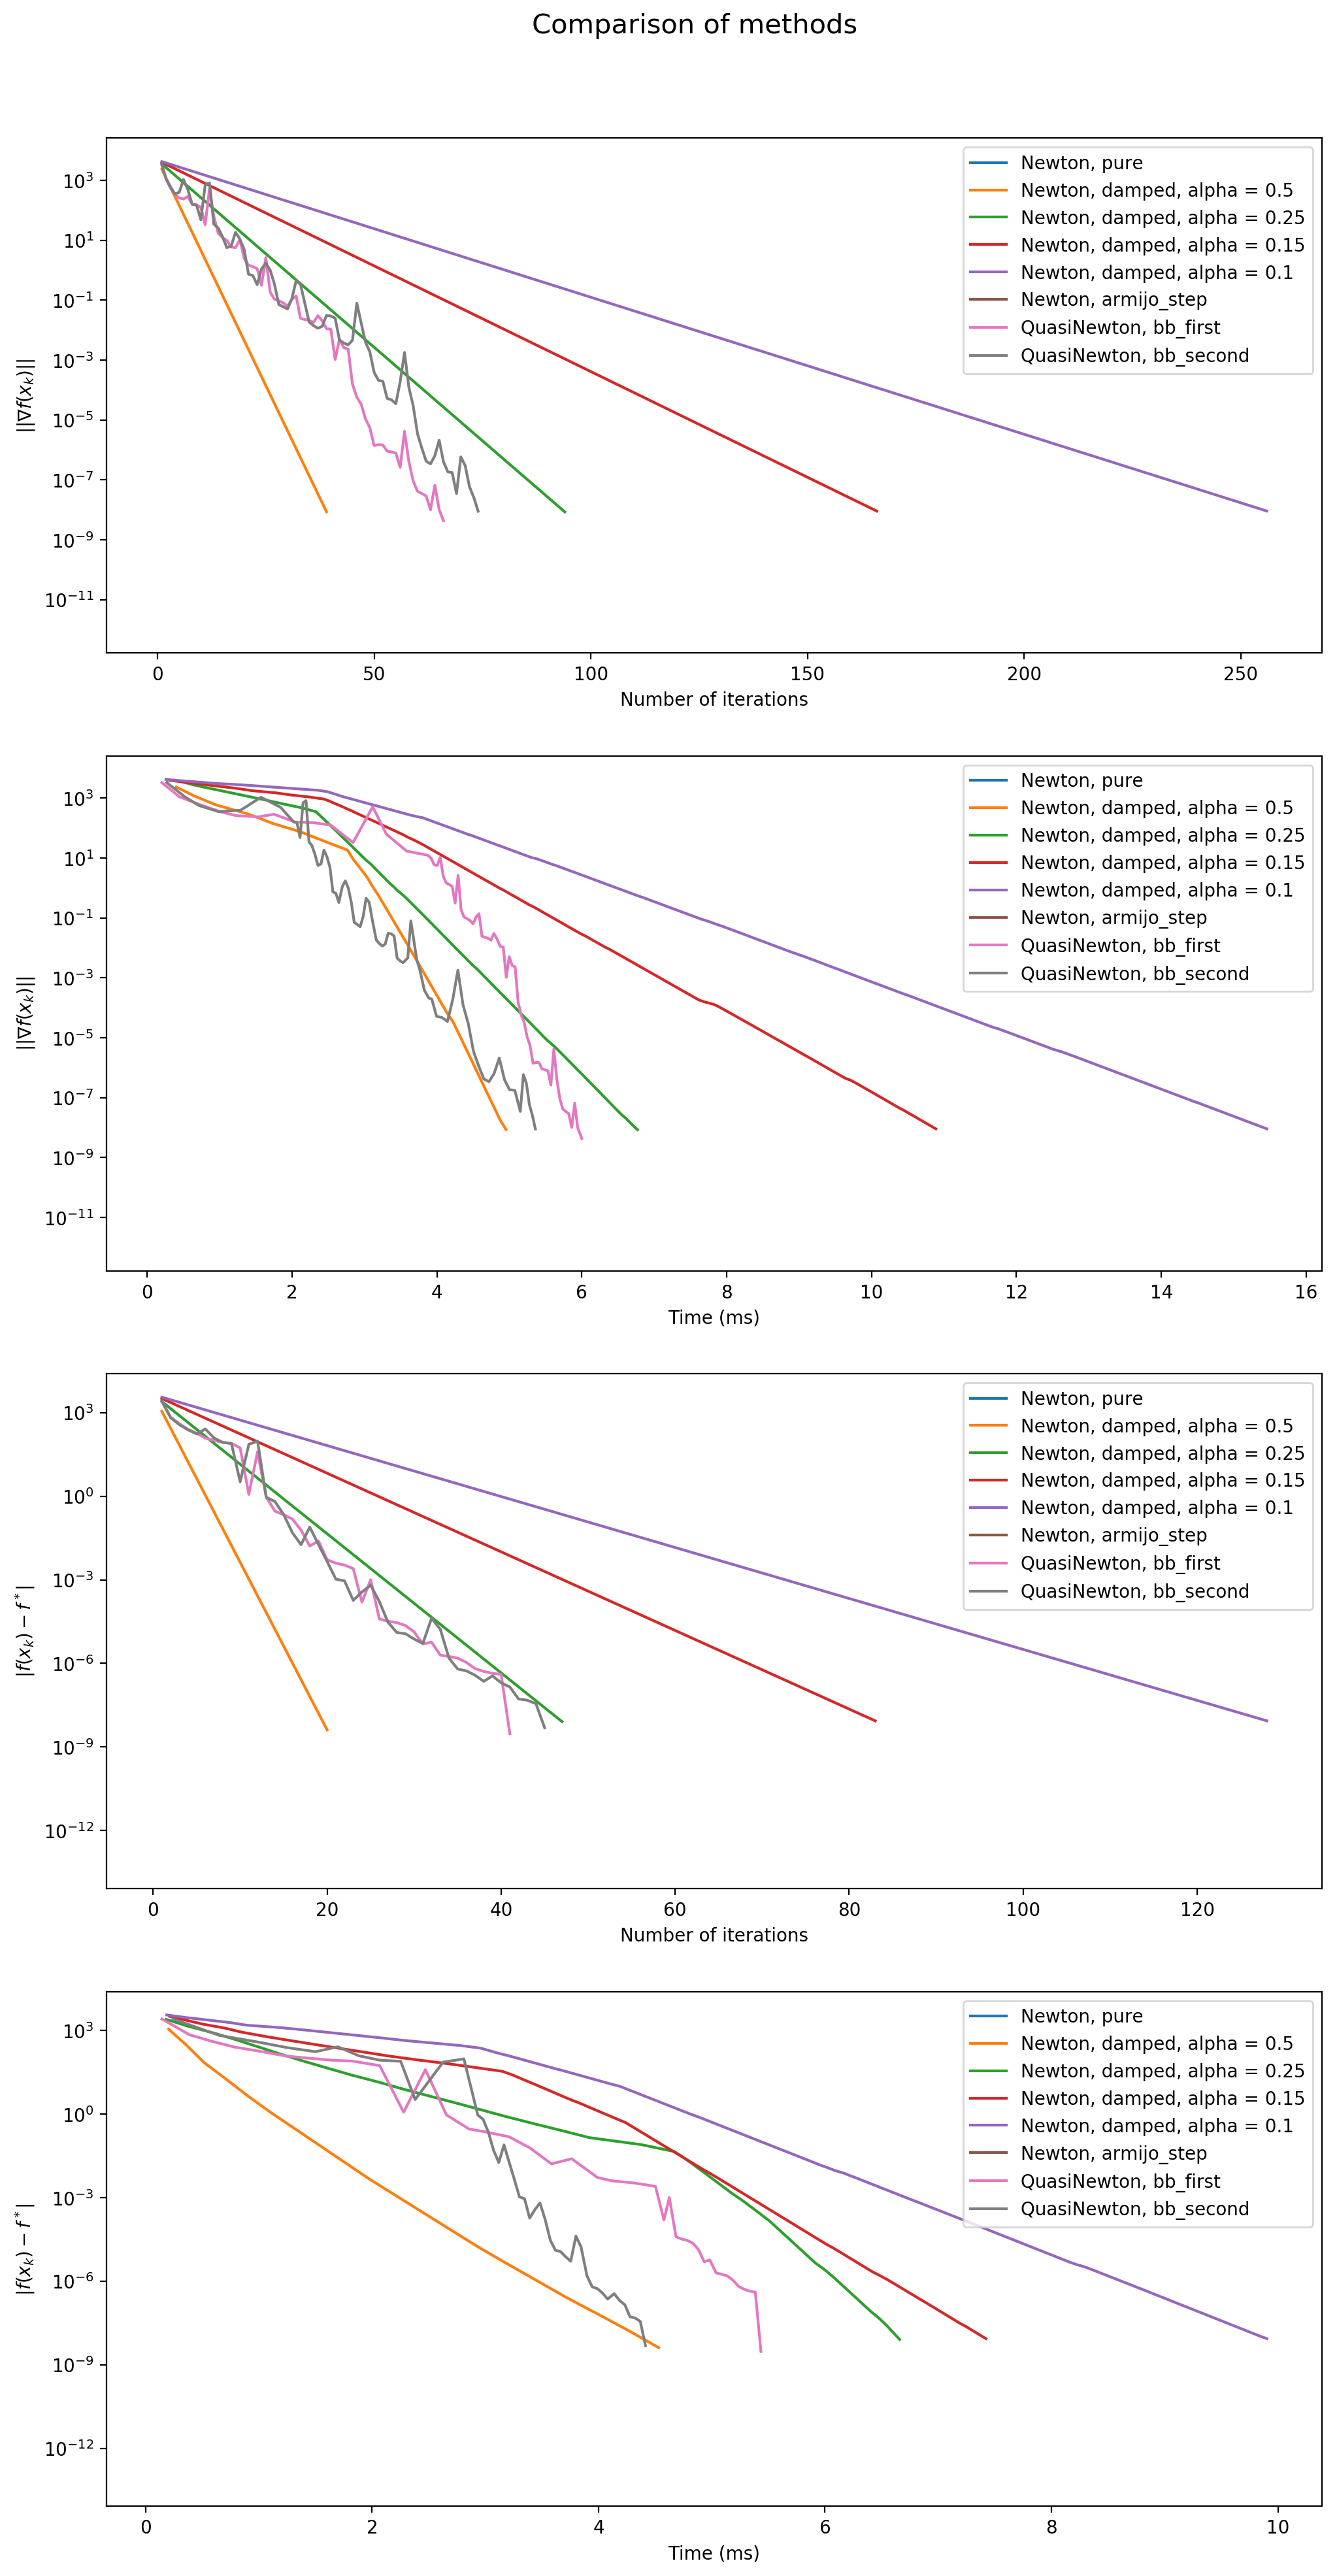

In [8]:
compare(f_stoch, gradf_stoch, hessf_stoch, np.random.rand(M), 1e-8, 600, [0.5, 0.25, 0.15, 0.1])

### Worst-case approximation

In [9]:
def solve_wc(get_funcs_wc, x0, epsilon, num_iter, method,
             step, convergence=grad_conv, conv_arg=None, value=None):
    meth_args = {"f_true": conv_arg, "alpha": value}
    results = []
    values = []
    for q in [-1, 1]:
        f, gradf, hessf = get_funcs_wc(q)
        res = method(f, gradf, hessf, x0, epsilon, num_iter, step,
                     convergence, **meth_args)
        results.append(res)
        values.append(f(res['x']))
    i = np.argmax(values)
    x = results[i]['x']
    func = values[i]
    
    
    label = method.__name__ + ", " + step.__name__
    if value is not None:
        label += ", alpha = " + str(value)
    print(label)
    print('Values: ', values)
    print('Max: ', func)
    print('x: ', x)
    
    for key in ['num_iter', 'time']:
        print(key, ": ", results[0][key] + results[1][key])
    print('\n')
    

def compare_wc(get_funcs_wc, x0, epsilon, num_iter, damped_values):
    # Best solution for func_conv
    results = []
    values = []
    for q in [-1, 1]:
        f, gradf, hessf = get_funcs_wc(q)
        res = Newton(f, gradf, hessf, x0, epsilon**3, num_iter * 100)
        results.append(res)
        values.append(f(res['x']))
    f_true = np.amax(values)
    
    convergence = [grad_conv, func_conv]
    conv_arg = [None, f_true]
    method = [Newton, Newton, Newton, QuasiNewton, QuasiNewton]
    step = [pure, damped, armijo_step, bb_first, bb_second]

    for i in range(len(convergence)):
        print("\n--------------- %s ---------------\n" % convergence[i].__name__)
        for j in range(len(step)):
            if step[j].__name__ == 'damped':
                for val in damped_values:
                    solve_wc(get_funcs_wc, x0, epsilon, num_iter, method[j],
                             step[j], convergence[i], conv_arg[i], value=val)
            else:
                solve_wc(get_funcs_wc, x0, epsilon, num_iter, method[j],
                         step[j], convergence[i], conv_arg[i])

In [10]:
def get_funcs_wc(q):
    A2 = A0 + q * A1
    f = lambda x: np.linalg.norm(A2 @ x - b)**2
    gradf = lambda x: 2 * A2.T @ (A2 @ x - b)
    hessf = lambda x: 2 * A2.T @ A2
    return f, gradf, hessf

In [11]:
compare_wc(get_funcs_wc, np.random.rand(M), 1e-8, 1000, [0.5, 0.25, 0.15, 0.1])


--------------- grad_conv ---------------

Newton, pure
Values:  [253.2339982400422, 270.51311045220865]
Max:  270.51311045220865
x:  [-0.2224402   0.23669838 -0.29073399  0.53339498 -0.24708276 -0.33178077
  0.19364109 -1.01718097  0.65016696 -0.31527828]
num_iter :  2
time :  0.34034399141091853


Newton, damped, alpha = 0.5
Values:  [253.23399824004227, 270.51311045220854]
Max:  270.51311045220854
x:  [-0.2224402   0.23669838 -0.29073399  0.53339498 -0.24708276 -0.33178077
  0.19364109 -1.01718097  0.65016696 -0.31527828]
num_iter :  78
time :  6.034615988028236


Newton, damped, alpha = 0.25
Values:  [253.2339982400422, 270.51311045220865]
Max:  270.51311045220865
x:  [-0.2224402   0.23669838 -0.29073399  0.53339498 -0.24708276 -0.33178077
  0.19364109 -1.01718097  0.65016696 -0.31527828]
num_iter :  188
time :  9.633350011426955


Newton, damped, alpha = 0.15
Values:  [253.2339982400422, 270.51311045220865]
Max:  270.51311045220865
x:  [-0.2224402   0.23669838 -0.29073399  0.5333